## 0. Importing libraries and set up device agnostic code

In [1]:
# Import libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets

In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [3]:
import requests
import zipfile
from pathlib import Path


# setup data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists.")
else:
  print(f"{image_path} does not exist, creating one....")
  image_path.mkdir(parents=True, exist_ok = True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downlaoding pizza sushi and steak data...")
  f.write(request.content)

# Unzip the data zip folder
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping the pizza steak and sushi data")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one....
Downlaoding pizza sushi and steak data...
Unziping the pizza steak and sushi data


## 2. Becoming one with data

In [4]:
import os

def walk_through_data(dir_path):
  """Walk through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [5]:
walk_through_data(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [6]:
# Setup training and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Random image path: data/pizza_steak_sushi/train/pizza/928670.jpg
Image class: pizza
Image height: 512
Image width: 512


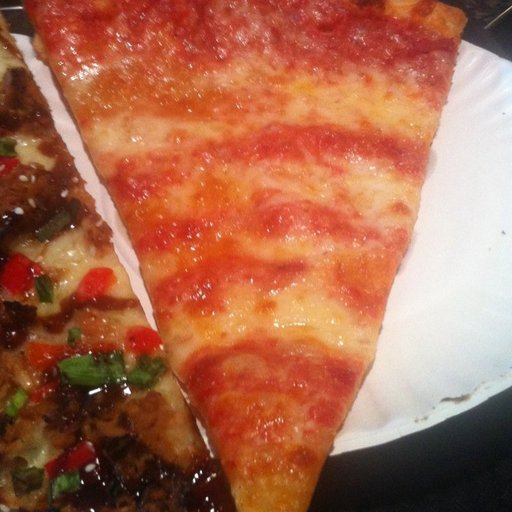

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

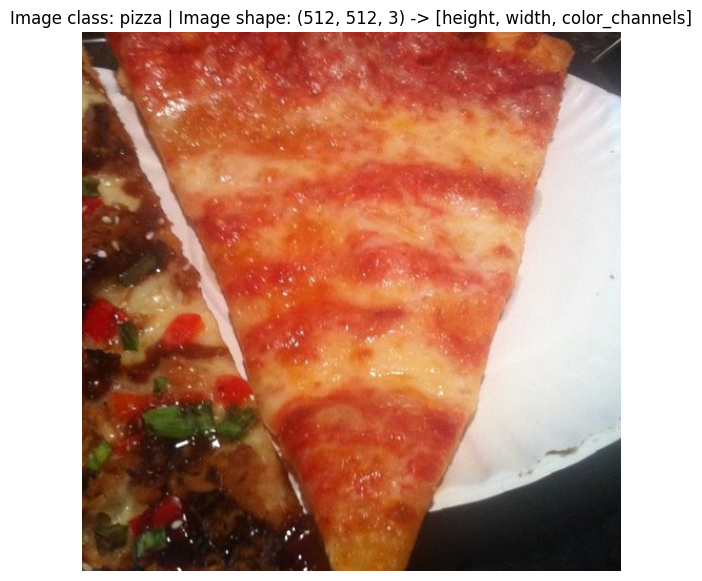

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming Data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

### 3.1 Transform data

In [10]:
# Write a transform for a image
data_transform = transforms.Compose(
    [
        # Resize images
        transforms.Resize(size = (64, 64)),

        # Flip the images
        transforms.RandomHorizontalFlip(p=0.5),

        # Turn into tensor
        transforms.ToTensor()
    ]
)

data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

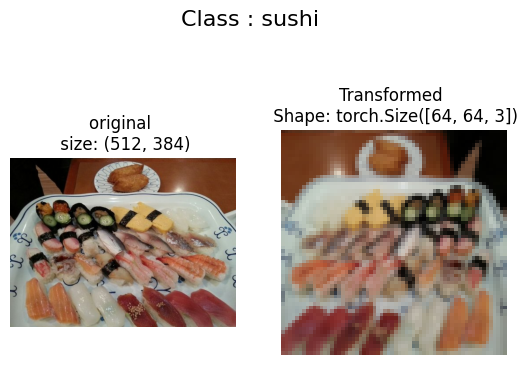

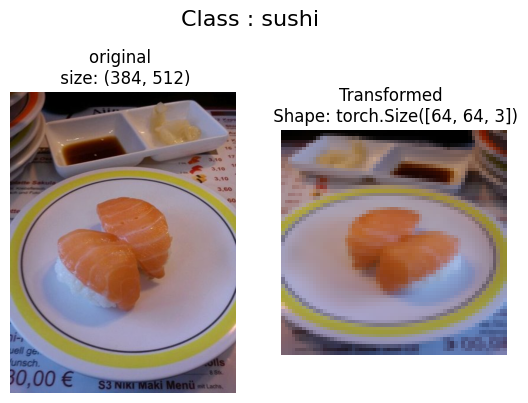

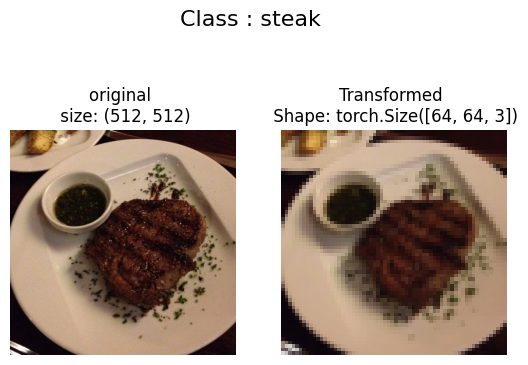

In [11]:
def plot_transformed_images(image_paths, transform, n = 3, seed=42):
  """ Selects random images from a path of images, trnasforms them and plots them"""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original \n size: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed = 42)

## 4.  Option 1 : Loading image data using ImageFolder

In [12]:
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform = data_transform, # For data
                                  target_transform=None # For label
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                                 transform= data_transform
                                 )

train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the length of datasets
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[199][0], train_data[199][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7373, 0.5412, 0.5255,  ..., 0.2275, 0.3569, 0.3765],
         [0.5373, 0.4784, 0.4314,  ..., 0.2392, 0.3843, 0.4510],
         [0.4431, 0.3647, 0.3059,  ..., 0.3098, 0.4196, 0.4784],
         ...,
         [0.3490, 0.3294, 0.3098,  ..., 0.8824, 0.8431, 0.8078],
         [0.4314, 0.4157, 0.3961,  ..., 0.8784, 0.8353, 0.7922],
         [0.5137, 0.4941, 0.4784,  ..., 0.8784, 0.8353, 0.7765]],

        [[0.4549, 0.3725, 0.4784,  ..., 0.1529, 0.2392, 0.2510],
         [0.3765, 0.4039, 0.4078,  ..., 0.1686, 0.2706, 0.3216],
         [0.3608, 0.3255, 0.2588,  ..., 0.2392, 0.3059, 0.3451],
         ...,
         [0.3490, 0.3216, 0.2941,  ..., 0.8824, 0.8431, 0.8039],
         [0.4431, 0.4157, 0.3922,  ..., 0.8863, 0.8392, 0.7922],
         [0.5255, 0.5098, 0.4863,  ..., 0.8824, 0.8314, 0.7686]],

        [[0.2118, 0.2667, 0.4980,  ..., 0.1255, 0.1961, 0.1922],
         [0.2706, 0.3922, 0.4471,  ..., 0.1294, 0.2078, 0.2471],
         [0.3608, 0.3490, 0.2667,  ..., 0.19

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


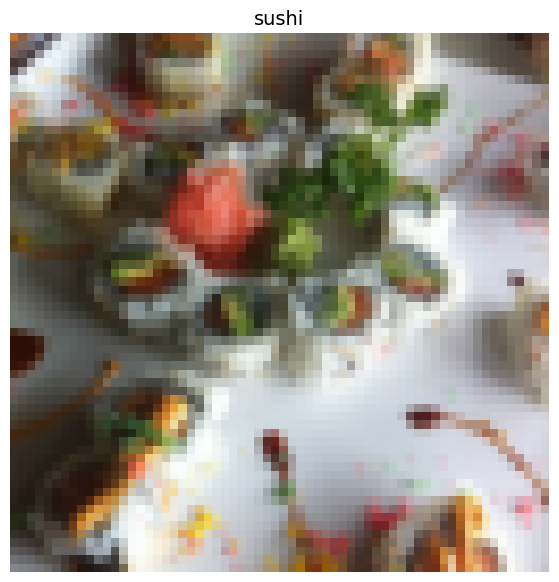

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into DataLoader's

In [18]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset= train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cfca233f670>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfca233f400>)

In [19]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [20]:
img, label = next(iter(train_dataloader))

# Batch Size will no be 1
print(f"Image Shape: {img.shape} --> [Batch_size, Channel, Height, Width]")
print(f"Label : {label.shape}")


Image Shape: torch.Size([1, 3, 64, 64]) --> [Batch_size, Channel, Height, Width]
Label : torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.Dataset.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})


### 5.1 Creating a helper function to get class names

In [23]:
# Setup path for target diectory
target_directory = train_dir

print(f"Target Dir : {target_directory}" )

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir (target_directory ))])
class_names_found

Target Dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())


    # 2. Raise an error if class names could not be found
    if not classes:
      raise FileNotFoundError(f"Could not find any classes in {directory}... Please check file structure ")

    # 3. Creare a dictionary of index labels
    class_to_idx = {class_name:i for i , class_name in enumerate(classes)}
    return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

In [26]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [27]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [28]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7cfca2bd5e70>,
 <__main__.ImageFolderCustom at 0x7cfca2bd7c10>)

In [29]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [30]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [31]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [32]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True



### 5.3 Create a function to display random images

In [33]:
# Create a function to take in dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape : bool = True,
                          seed : int = None):

  # 2. Adjsut display
  if n > 10:
    n = 10
    display_shape = False
    print(f" For displaym pursposes, n shouldnt be greater than 10, Setting to 10")

  # 3. SET THE SEED
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)


  # 5. Set up plot
  plt.figure(figsize = (16, 8))

  # 6. Loop through random images and plot thrm
  for i, targ_sampl in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sampl][0], dataset[targ_sampl][1]

    # 7. Adjust tensor dimesions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) ## [h, w, c] for plotting

    # plot adjusted samples
    plt.subplot(1, n, i + 1 )
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class : {classes[targ_label]}"
      if display_shape :
        title = title + f"\nShape: {targ_image_adjust.shape}"

    plt.title(title)

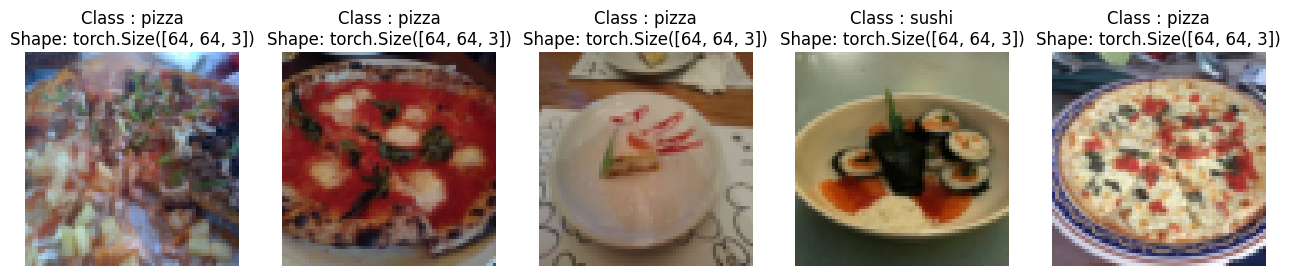

In [34]:
# Display random images from ImageFolder created dataset
display_random_images(
    train_data,
    n = 5,
    classes = class_names,
    seed = None
)

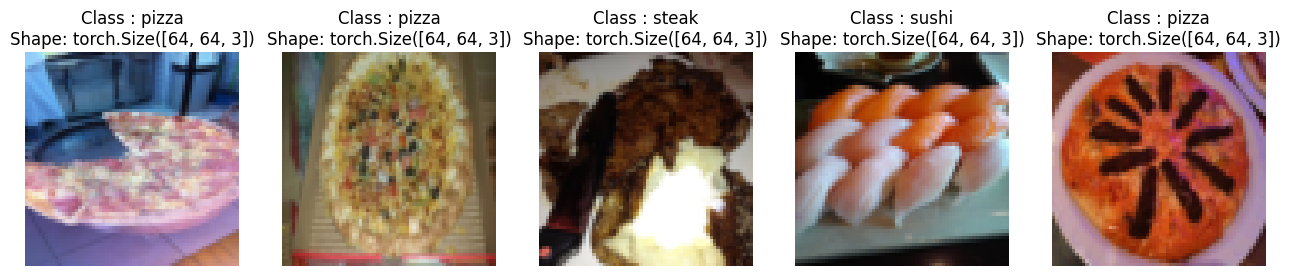

In [35]:
# Display random images from ImageFolder custome
display_random_images(
    train_data_custom,
    n = 5,
    classes = class_names,
    seed = None
)

### 5.4 Turn Custome Loaded images into DataLoader's

In [36]:
from torch.utils.data import DataLoader


# Batch Size
BATCH_SIZE = 32


train_dataloader_custom = DataLoader(
    dataset = train_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    shuffle = True
)

test_dataloader_custom = DataLoader(
    dataset = test_data_custom,
    batch_size = BATCH_SIZE,
    num_workers= 0,
    shuffle = False
)

In [37]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7cfc8fc82f80>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfc8fc83d60>)

In [38]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))


# Print shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other Forms of Data Augmentation

In [39]:
## TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

In [40]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/794647.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/307738.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1280119.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/700405.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1214108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3426958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360207.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/121940.jpg')]

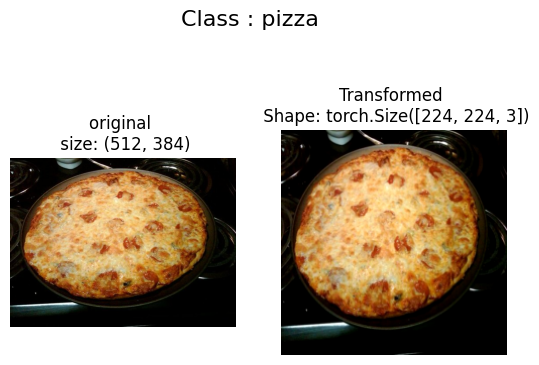

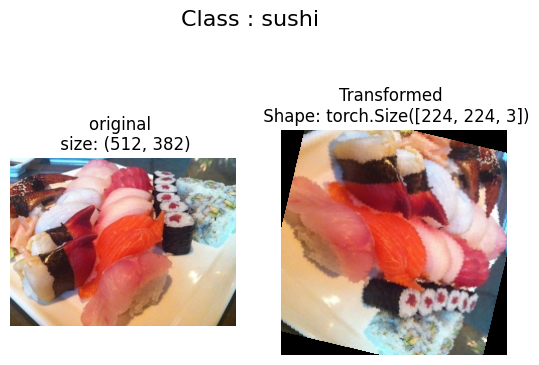

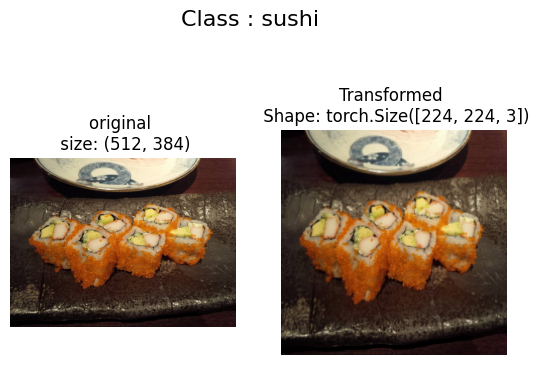

In [41]:
# Plot random  transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    seed = None,
    n =3
)

## 7. TinyVGG without Data Augmentation

### 7.1 Creating transform and loading data for Model 0

In [42]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size = [64, 64]),
    transforms.ToTensor()
])

In [43]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root= train_dir,
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)


# 2. turn  the datasets into dataloader's
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create dataloader
train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    shuffle = True
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [44]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [45]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


### 7.4 Use `torchinfo` to get an idea of shapes going through our model


In [46]:
pip install torchinfo

In [47]:
from torchinfo import summary

# get summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia


### 7.5 Create train & test loop functions

In [48]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Set up train loss and train accuracy loss
  train_loss, train_acc = 0, 0

  # Loop through dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim =1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjusr metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [49]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creeating train() function to combine train_step and test_step

In [50]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1433 | test_acc: 0.1979
Total training time: 8.384 seconds


### 7.8 Plot the loss curves of Model 0

In [52]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

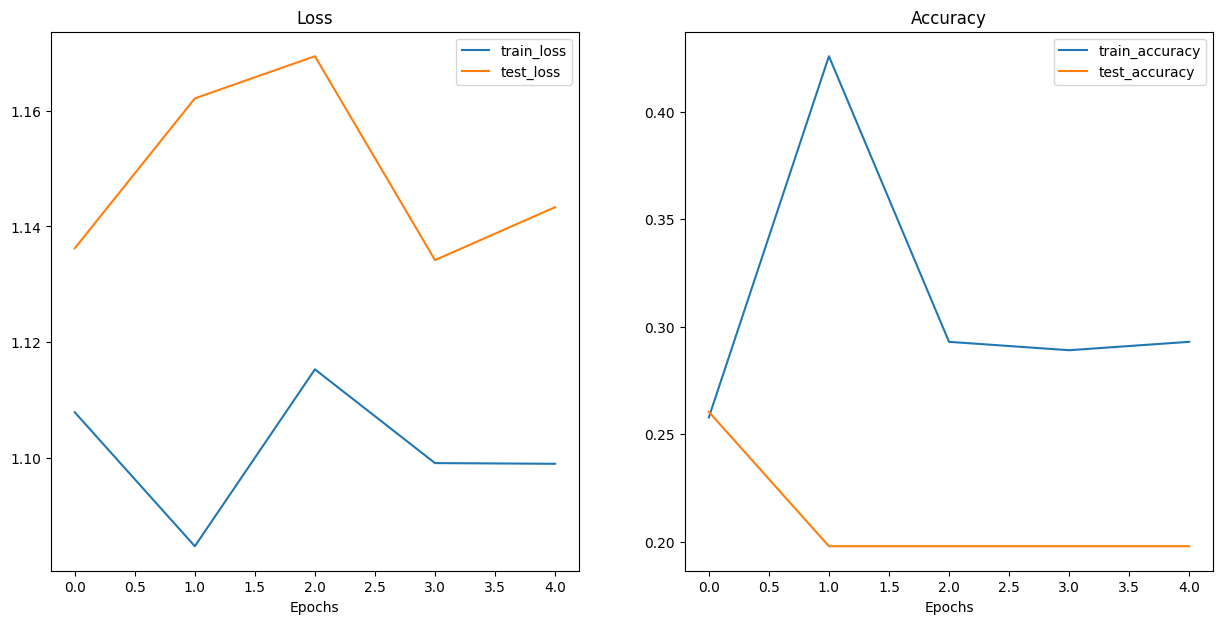

In [53]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [54]:
# create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose(
    [
        transforms.Resize(size =(64,64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Datasets and Dataloaders with Data Augmentation

In [55]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform_simple
)

In [56]:
# Turn our datasets in to Dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS  = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        num_workers= NUM_WORKERS,
                                        shuffle = True)

test_dataloader_simple = DataLoader(dataset= test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

### 9.3 Construct and train Model 1

In [57]:
# Create model_1 and send it to target device
torch.manual_seed(42)

model_1 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data_augmented.classes)
).to(device)

In [58]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [59]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0811 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1623 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604
Total training time: 11.461 seconds


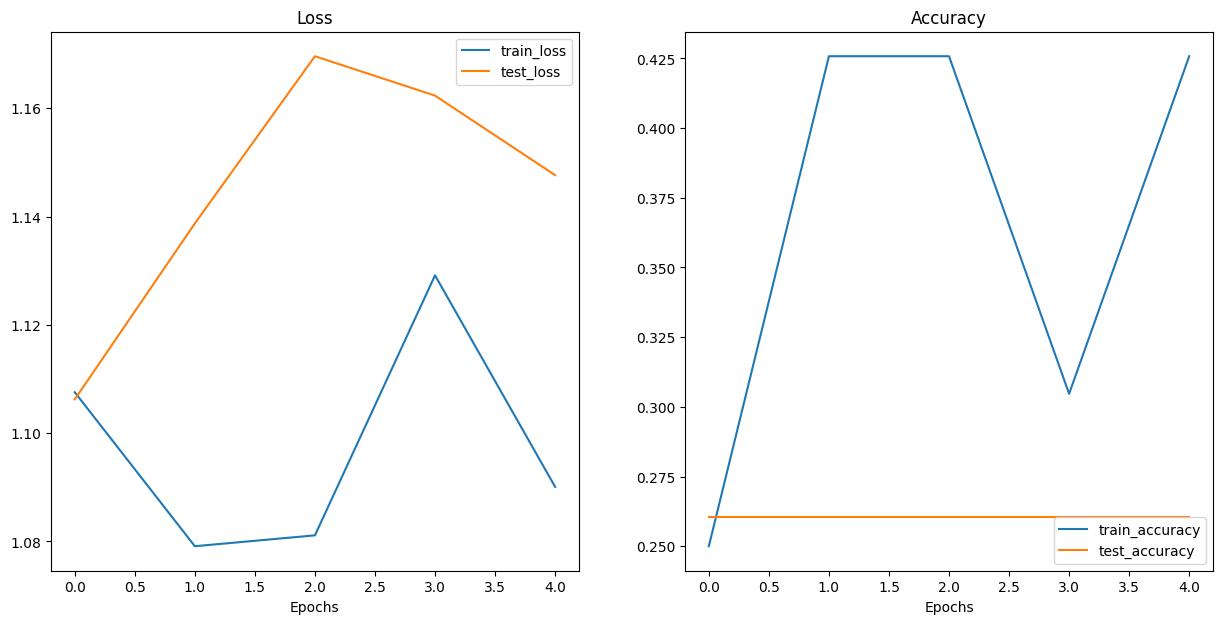

In [60]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [61]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115261,0.292969,1.169467,0.197917
3,1.099034,0.289062,1.134172,0.197917
4,1.098916,0.292969,1.143334,0.197917


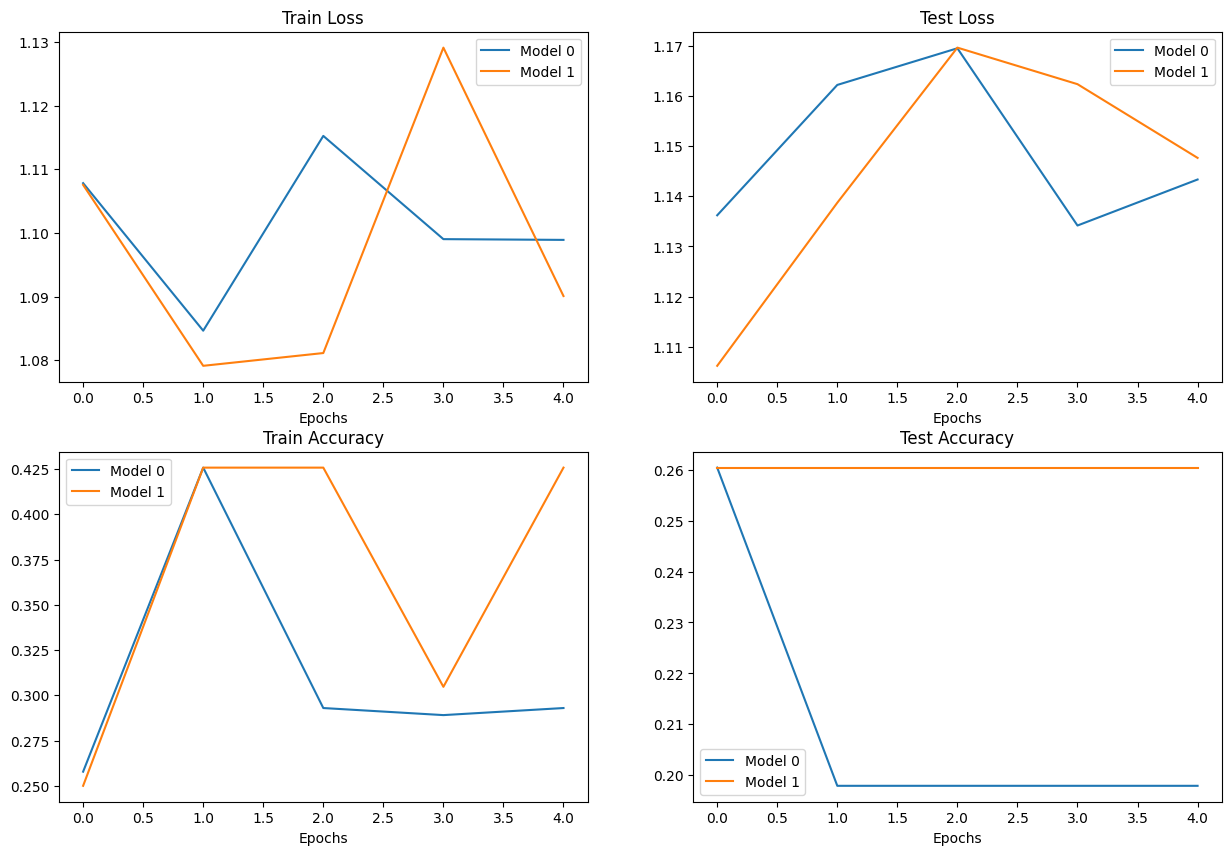

In [62]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

In [64]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

In [65]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

### 11.2 Predicting on custom images with a trained PyTorch model

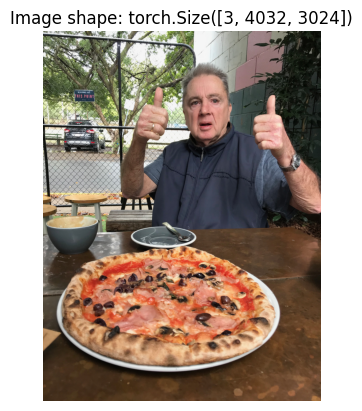

In [67]:
# Plot custom image
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_uint8.shape}")
plt.axis(False);

In [68]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [71]:
# Load the custome image and convert to torch.float32

custom_image  = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

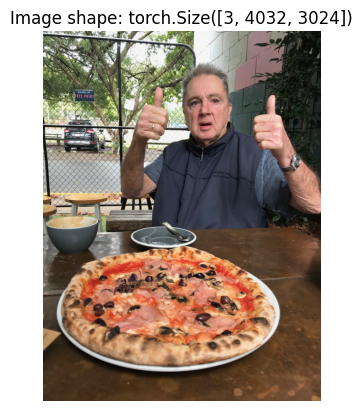

In [72]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [76]:
# Create transform pipeline to resize the image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64, 64))
])


# Transform target image
custome_image_transformed = custom_image_transform(custom_image)

# Print out image data
print(f"Custom image tensor:\n{custome_image_transformed}\n")
print(f"Custom image shape: {custome_image_transformed.shape}\n")
print(f"Custom image dtype: {custome_image_transformed.dtype}")

Custom image tensor:
tensor([[[0.4673, 0.5292, 0.5601,  ..., 0.0976, 0.0604, 0.0578],
         [0.4014, 0.4351, 0.4291,  ..., 0.0671, 0.0714, 0.0848],
         [0.5172, 0.4849, 0.4472,  ..., 0.0613, 0.0605, 0.0694],
         ...,
         [0.2999, 0.2819, 0.2705,  ..., 0.4570, 0.4019, 0.3955],
         [0.2767, 0.2697, 0.2606,  ..., 0.4620, 0.4208, 0.3763],
         [0.2502, 0.2557, 0.2690,  ..., 0.4894, 0.6088, 0.5344]],

        [[0.4926, 0.5517, 0.5773,  ..., 0.1246, 0.0688, 0.0680],
         [0.4545, 0.4876, 0.4600,  ..., 0.0806, 0.0824, 0.1022],
         [0.5485, 0.5217, 0.4785,  ..., 0.0689, 0.0704, 0.0882],
         ...,
         [0.2066, 0.1971, 0.1882,  ..., 0.3125, 0.2772, 0.2778],
         [0.1922, 0.1870, 0.1805,  ..., 0.3217, 0.2926, 0.2662],
         [0.1730, 0.1777, 0.1865,  ..., 0.3425, 0.4223, 0.3684]],

        [[0.4510, 0.5250, 0.5622,  ..., 0.0806, 0.0408, 0.0439],
         [0.3132, 0.3614, 0.3848,  ..., 0.0508, 0.0532, 0.0766],
         [0.4766, 0.4248, 0.3951,  ..

In [78]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custome_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [81]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custome_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custome_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custome_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [82]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1173,  0.0343, -0.1463]], device='cuda:0')
Prediction probabilities: tensor([[0.3719, 0.3423, 0.2857]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


### 11.3 Putting custom image prediction together: building a function

In [83]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

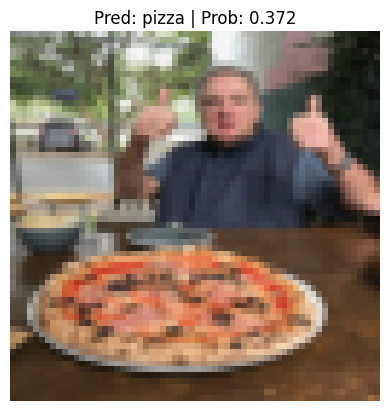

In [86]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)